# Rate of Precipitation

## Learning Objectives
In this tutorial, we will create a visualization of precipitation rate for Feb 24, 2023, when an atmospheric river brought rain to the coastal and the Central Valley regions. When the water vapor moved up and over the Sierra Nevada mountain range, it rapidly cooled to form snow.

## Dataset
We will use GPM IMERG Final Precipitation L3 Daily dataset for this tutorial.  The IMERG Precipitation Rate provides rain rate and snow rate in millimeters per hour (mm/hr). It is estimated by the Integrated Multi-satellitE Retrievals for Global Precipitation Measurement (GPM) (IMERG) algorithm. The IMERG algorithm uses passive-microwave data from the GPM constellation of satellites and also infrared data from geosynchronous satellites. IMERG “morphs” observations to earlier or later times using wind obtained from weather-model analyses. The daily IMERG dataset is derived from the half-hourly GPM_3IMERGHH. The derived result represents the final estimate of the daily mean precipitation rate in mm/day.

The IMERG data has 0.1 x 0.1 degree latitude-longitude resolution (approximately 11 by 11 km at the Equator). The grid covers the globe, although precipitation cannot always be estimated near the Poles. The dataset and algorithm is described in the [data user guide](https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/doc/README.GPM.pdf) and the [Algorithm Theoretical Basis Document (ATBD)](https://arthurhou.pps.eosdis.nasa.gov/Documents/IMERG_V07_ATBD_final.pdf). 

Please cite the dataset as following:
> Huffman, G.J., E.F. Stocker, D.T. Bolvin, E.J. Nelkin, Jackson Tan (2023), GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 degree V07, Edited by Andrey Savtchenko, Greenbelt, MD, Goddard Earth Sciences Data and Information Services Center (GES DISC), https://doi.org/10.5067/GPM/IMERGDF/DAY/07

## Requirements
1. **Compute environment**: This notebook can only be run in an AWS Cloud instance running in the `us-west-2` region.
2. **Earthdata Login**. An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.
3. **Additional Requirements**: This tutorial requires the following Python modules installed in your system: earthaccess. To install the necessary Python modules, you can run:
```bash
pip install -r earthaccess 
```

In [1]:
import earthaccess
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

### 1. Authentication
Access to NASA OPeNDAP requires NASA Earthdata authentication. We recommend authenticating your [Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/) information using the earthaccess python library as follows:

In [2]:
auth = earthaccess.login(strategy="netrc") # works if the EDL login already been persisted to a netrc
if not auth.authenticated:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/28/2023
Using .netrc file for EDL


### 2. Search
We will use `earthaccess` module for search for dataset granules from February 24, 2023.

In [3]:
# IMERG FINAL L3 PRCP DOI 
doi = '10.5067/GPM/IMERGDF/DAY/07'

# time-bound for the year 2020
date1 = "2023-02-24"

granules = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=(date1, date1)
)

Granules found: 1


### 3. Open granule
Let's open the granule (s3 object) into a xarray. The `earthaccess` module manages temporary authentication that is needed for accessing data in NASA's Earthdata cloud.

In [4]:
file_handlers = earthaccess.open(granules)
ds = xr.open_dataset(file_handlers[0], decode_coords="all")

 Opening 1 granules, approx size: 0.03 GB
using endpoint: https://data.gesdisc.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

### 4. Prepare data
Let's print out all the variable names.

In [5]:
for v in ds.variables:
    print(v)

precipitation
precipitation_cnt
precipitation_cnt_cond
MWprecipitation
MWprecipitation_cnt
MWprecipitation_cnt_cond
randomError
randomError_cnt
probabilityLiquidPrecipitation
lon
lat
time
time_bnds


Of the variables listed above, we are interested in three variables `precipitation`, `precipitation_cnt_cond`, and `probabilityLiquidPrecipitation`. Let's print their attributes.

In [6]:
ds.variables['precipitation'].attrs

{'units': 'mm/day',
 'long_name': 'Daily mean precipitation rate (combined microwave-IR) estimate. Formerly precipitationCal.'}

In [7]:
ds.variables['precipitation_cnt_cond'].attrs

{'units': 'count',
 'long_name': 'Count of half-hourly precipitation retrievals for the day where precipitation is at least 0.01 mm/hr'}

In [8]:
ds.variables['probabilityLiquidPrecipitation'].attrs

{'units': 'percent',
 'long_name': 'Probability of liquid precipitation',
 'description': 'Probability of liquid precipitation estimated with a diagnostic parameterization using ancillary data. 0=missing values; 1=likely solid; 100=likely liquid or no precipitation.  Screen by positive precipitation or precipitation_cnt_cond to locate meaningful probabilities.'}

Let's first select time step from Feb 24, 2023. We will then create a snow layer (grid cells with probabilityLiquidPrecipitation = 1) and a rainfall layer (grid cells with probabilityLiquidPrecipitation != 1). We will also limit grids to those with at least 0.01 mm/hr precipitation (precipitation_cnt_cond>0).

In [9]:
ds_feb24 = ds.sel(time="2023-02-24")
snow = ds_feb24.precipitation.where((ds_feb24.precipitation_cnt_cond>0) & 
                                    (ds_feb24.probabilityLiquidPrecipitation == 1))
prcp = ds_feb24.precipitation.where((ds_feb24.precipitation_cnt_cond>0) & 
                                    (ds_feb24.probabilityLiquidPrecipitation != 1))

### 5. Plot

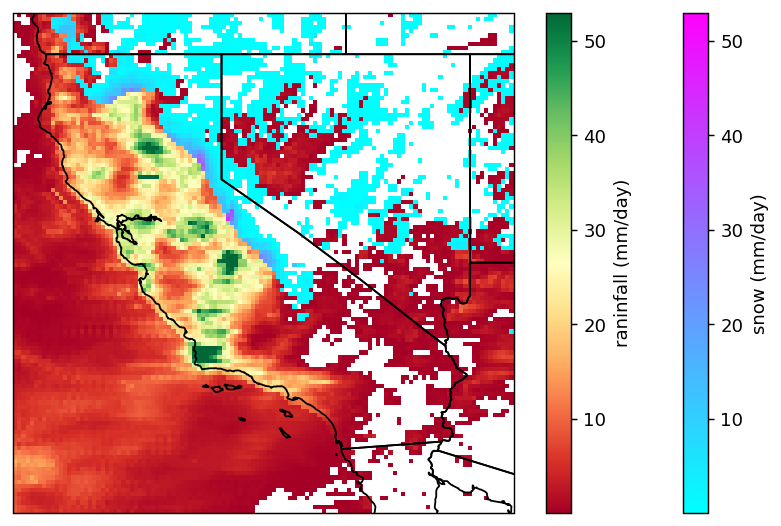

In [11]:
# create the plot
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(8,5), dpi=130, facecolor="w", subplot_kw=dict(projection=proj))
snowax = plt.pcolormesh(prcp.lon, prcp.lat, snow.T, vmax=53, cmap='cool')
prcpax = plt.pcolormesh(prcp.lon, prcp.lat, prcp.T, vmax=53, cmap='RdYlGn')
plt.colorbar(snowax, ax=ax, label="snow (mm/day)")
plt.colorbar(prcpax, ax=ax, label="raninfall (mm/day)")
ax.add_feature(cfeature.STATES)
ax.set_extent([-125, -113.0, 31.0, 43.0], crs=proj)
plt.show()